In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16052618198303747308
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7391222063567404728
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7511012148
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1860601580348409303
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6568189262845579997
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0815 20:31:13.116192 139944151082752 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 20:31:13.116928 139944151082752 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0815 20:31:13.117800 139944151082752 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0815 20:31:13.124577 139944151082752 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use 

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
#read in the csvs obtained from 03_tags_clustering
# chem = pd.read_csv("../data/equation/chemistry_post_eq_tag_id.csv", lineterminator='\n')
# physics = pd.read_csv("../data/equation/physics_post_eq_tag_id.csv", lineterminator='\n')
physics = pd.read_csv("../data/equation/physics_post_eq_tag_id_2.csv", lineterminator='\n')
# bio = pd.read_csv("../data/equation/biology_post_eq_tag_id.csv", lineterminator='\n')

In [118]:
# df = pd.concat([chem, physics, bio], ignore_index=True)
df = pd.concat([physics], ignore_index=True)
df.head()

,Equation,Label,Cluster_label,Id,Tags
0,\frac{40\ \text{mph} +60\ \text{mph}}{2} = 50\...,physics,physics-everything-else,29,<homework-and-exercises><kinematics><speed>
1,\frac{240\ \text{mi}}{50\ \text{mph}} = 4.8 \ ...,physics,physics-everything-else,29,<homework-and-exercises><kinematics><speed>
2,3 + 2 = 5,physics,physics-everything-else,29,<homework-and-exercises><kinematics><speed>
3,\frac{1}{r^2},physics,physics-everything-else,93,<electrostatics><spacetime><spacetime-dimensio...
4,\frac{1}{r^2},physics,physics-everything-else,93,<electrostatics><spacetime><spacetime-dimensio...


In [119]:
df = df[df['Cluster_label'] != 'physics-everything-else']

In [74]:
# df = df[df.apply(lambda row: len(row.Equation) > 3, axis = 1)]

In [124]:
df.shape[0]

177986

In [125]:
len(df[df['Equation'].isnull()])

56

In [126]:
df.dropna(subset = ['Equation'], inplace = True)

In [127]:
df.shape[0]

177930

In [128]:
df = df[df.apply(lambda row: "=" in row.Equation, axis = 1)]

In [129]:
df.shape[0]

56269

In [130]:
df.rename(columns={"Label": "Source"}, inplace = True)

/home/mdogan/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [131]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.Id
    post_ids = df.Id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.Id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [132]:
np.random.seed(1)
print('Null Data: ', df.Equation.isnull().sum())
df.dropna(subset=['Equation'], inplace=True)
df = df.drop_duplicates(subset=['Equation', 'Source', 'Cluster_label'])
train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  0
Training rows: 41998
Val rows: 4402
Test rows: 4717


/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
train_df.head()

,Equation,Source,Cluster_label,Id,Tags
98,F > f_s = \mu_s F_N,physics,physics-newtonian-mechanics,541,<forces><newtonian-mechanics><friction>
154,\frac{(-i\hbar\nabla)^2}{2m} \psi = i\hbar\pa...,physics,physics-quantum-mechanics,741,<quantum-mechanics><electromagnetism><differen...
155,"A=(c\phi,\mathbf{A})",physics,physics-quantum-mechanics,741,<quantum-mechanics><electromagnetism><differen...
166,M=\mathbb{R}^3\times\mathbb{R},physics,physics-field-theory,768,<quantum-mechanics><electromagnetism><quantum-...
174,\vec v = v^\mu \frac{\partial}{\partial x^\mu},physics,physics-field-theory,768,<quantum-mechanics><electromagnetism><quantum-...


In [134]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [135]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.Equation)

# convert string to list of int
train_df['seq'] = train_df.Equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.Equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.Equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.Cluster_label.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['Label'] = train_df.Cluster_label.map(label_map)
val_df['Label'] = val_df.Cluster_label.map(label_map)
test_df['Label'] = test_df.Cluster_label.map(label_map)


/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [136]:
encode_sequence('1234', tokenizer)

[1, 32, 64, 117, 190, 2]

In [137]:
tokenizer['4']

190

In [138]:
len(tokenizer.vocab)

210

In [139]:
label_map

{'physics-newtonian-mechanics': 0,
 'physics-quantum-mechanics': 1,
 'physics-field-theory': 2,
 'physics-general-relativity': 3}

In [140]:
train_df.sample(10)

,Equation,Source,Cluster_label,Id,Tags,seq,length,Label
382392,p_\|\cdot x_\|=E_pt-p_2x_2-p_3x_3,physics,physics-field-theory,430147,<homework-and-exercises><quantum-field-theory>...,"[1, 46, 55, 34, 138, 34, 14, 124, 6, 166, 76, ...",35,2
419814,\mathcal{N}\left(\lambda\right)=\sum_{n=1}^{M}...,physics,physics-quantum-mechanics,463822,<quantum-mechanics><condensed-matter><solid-st...,"[1, 34, 41, 98, 166, 93, 14, 98, 73, 123, 151,...",93,1
195228,"A(\vec{a},\lambda)=\pm 1",physics,physics-quantum-mechanics,243477,<quantum-mechanics><homework-and-exercises><qu...,"[1, 194, 89, 34, 191, 165, 14, 123, 98, 51, 35...",26,1
210931,\langle \lambda |L|\lambda \rangle = \lambda \...,physics,physics-quantum-mechanics,260863,<quantum-mechanics><operators><hilbert-space><...,"[1, 34, 73, 98, 143, 147, 73, 165, 76, 34, 73,...",79,1
373404,|e\rangle_H = |e(t)\rangle_H,physics,physics-quantum-mechanics,421572,<quantum-mechanics><homework-and-exercises><op...,"[1, 138, 165, 34, 85, 98, 143, 147, 73, 165, 5...",30,1
159278,n^\mu A_\mu = 0,physics,physics-field-theory,202819,<quantum-field-theory><gauge-theory><field-the...,"[1, 143, 140, 34, 41, 204, 76, 194, 55, 34, 41...",17,2
9908,"\psi(\tau=0,x,z)\psi_0(x,z)",physics,physics-field-theory,19968,<quantum-field-theory><path-integral>,"[1, 34, 46, 87, 69, 89, 34, 166, 98, 204, 97, ...",29,2
21069,(\mathcal{J}_k)^0_0 = (\mathcal{J}_k)^0_i = (\...,physics,physics-field-theory,35510,<quantum-field-theory><special-relativity><ang...,"[1, 89, 34, 41, 98, 166, 93, 14, 98, 73, 123, ...",69,2
66344,"T_k(x,t)=C(k)\cdot \sin{kx} \cdot e^{-k^2\alph...",physics,physics-quantum-mechanics,90779,<quantum-mechanics><thermodynamics><mathematic...,"[1, 33, 55, 19, 89, 121, 35, 166, 49, 97, 104,...",52,1
155346,W_\text{int} +p_1 ^2/2M+V_1=W_\text{int}+p_2 ^...,physics,physics-quantum-mechanics,196827,<quantum-mechanics><wavefunction>,"[1, 164, 55, 34, 166, 165, 121, 166, 123, 69, ...",57,1


In [141]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False, n_class: int = 3):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.n_class = n_class
        self.class_weight =  self.compute_class_weight(self.n_class) if self.weight else np.ones((self.n_class,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.Label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self, n_classes):
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.Label.values))


In [142]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [143]:
def clf_model(tokenizer, emb, n_kernels, kernel_width, n_class):
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(n_class, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [21]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])


# model3 (only equations with an equal sign): clustersize = 4, batch_size = 1024, emb = 32, n_kernels = 128, kernel_width = 3, epochs = 16

In [144]:
batch_size = 1024
n_class = 4
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True, n_class = n_class)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False, n_class = n_class)

In [145]:
emb = 32
n_kernels = 128
kernel_width = 3

In [146]:
model = clf_model(tokenizer, emb, n_kernels, kernel_width, n_class)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     6720        input_4[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [147]:
model.save('../result/model/model3_cluster4_epoch16.h5')

In [148]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=16,
    workers=4,
    use_multiprocessing=True
)

Epoch 1/16
42/42 [==============================] - 5s 123ms/step - loss: 1.1979 - sparse_categorical_accuracy: 0.4495 - val_loss: 1.1576 - val_sparse_categorical_accuracy: 0.4995
Epoch 2/16
42/42 [==============================] - 3s 60ms/step - loss: 1.0599 - sparse_categorical_accuracy: 0.5452 - val_loss: 1.0483 - val_sparse_categorical_accuracy: 0.5307
Epoch 3/16
42/42 [==============================] - 3s 61ms/step - loss: 1.0415 - sparse_categorical_accuracy: 0.5526 - val_loss: 1.0731 - val_sparse_categorical_accuracy: 0.5177
Epoch 4/16
42/42 [==============================] - 3s 61ms/step - loss: 1.0026 - sparse_categorical_accuracy: 0.5719 - val_loss: 0.9734 - val_sparse_categorical_accuracy: 0.6043
Epoch 5/16
42/42 [==============================] - 3s 64ms/step - loss: 0.9903 - sparse_categorical_accuracy: 0.5842 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.6050
Epoch 6/16
42/42 [==============================] - 3s 61ms/step - loss: 0.9978 - sparse_categorical_acc

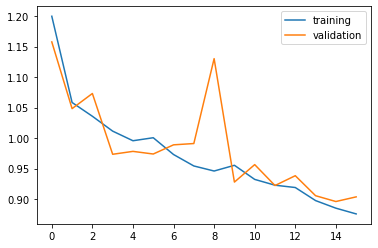

In [149]:
%matplotlib inline
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


# save loss data

In [150]:
import pickle

In [151]:
with open('../result/loss/model3_cluster4_epoch16', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [152]:
file = open('../result/loss/model3_cluster4_epoch16', 'rb')
data = pickle.load(file)

# Evaluation

## evaluation tools

In [153]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png')
    return ax

In [154]:
def predict_on_df(model, df, batch_size, n_class):
    dg = DataGenerator(df, batch_size=batch_size, shuffle=False, weight = False, n_class = n_class)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['Label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['Equation', 'pred_label', 'Cluster_label', 'pred_index', 'Label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [155]:
batch_size = 1024
n_class = 4
predictions = predict_on_df(model, test_df, batch_size, n_class)

/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [156]:
%matplotlib inline

In [157]:
predictions[predictions.apply(lambda row: row.Label == row.pred_index, axis = 1)].shape[0]/(predictions.shape[0])

0.5995336018655926

In [162]:
predictions.head()

,Equation,Source,Cluster_label,Id,Tags,seq,length,Label,pred_index,pred_label,pred_conf,match
125,F=m a,physics,physics-newtonian-mechanics,629,<newtonian-mechanics><jerk>,"[1, 58, 97, 41, 76, 98, 2]",7,0,0,physics-newtonian-mechanics,0.889306,True
577,\langle \sigma_l^z \sigma_{l+R}^z \rangle = \l...,physics,physics-quantum-mechanics,2014,<quantum-mechanics><statistical-mechanics><spi...,"[1, 34, 73, 98, 143, 147, 73, 165, 76, 34, 87,...",82,1,1,physics-quantum-mechanics,0.516460,True
578,R=1,physics,physics-quantum-mechanics,2014,<quantum-mechanics><statistical-mechanics><spi...,"[1, 112, 97, 32, 2]",5,1,3,physics-general-relativity,0.478055,False
579,G_1 = -\langle \sigma_l^x \sigma_{l+1}^x+ \sig...,physics,physics-quantum-mechanics,2014,<quantum-mechanics><statistical-mechanics><spi...,"[1, 108, 55, 32, 76, 97, 76, 134, 34, 73, 98, ...",79,1,2,physics-field-theory,0.539495,False
581,\langle \sigma^z_l \rangle=tr(\rho \sigma^z_l ),physics,physics-quantum-mechanics,2014,<quantum-mechanics><statistical-mechanics><spi...,"[1, 34, 73, 98, 143, 147, 73, 165, 76, 34, 87,...",49,1,1,physics-quantum-mechanics,0.607787,True


In [163]:
predictions.groupby(['Label'])['Label'].count()

Label
0    1029
1    2020
2     965
3     703
Name: Label, dtype: int64

Confusion matrix, without normalization
[[ 830   61   58   80]
 [ 289 1068  487  176]
 [ 133  185  526  121]
 [ 109   59  131  404]]


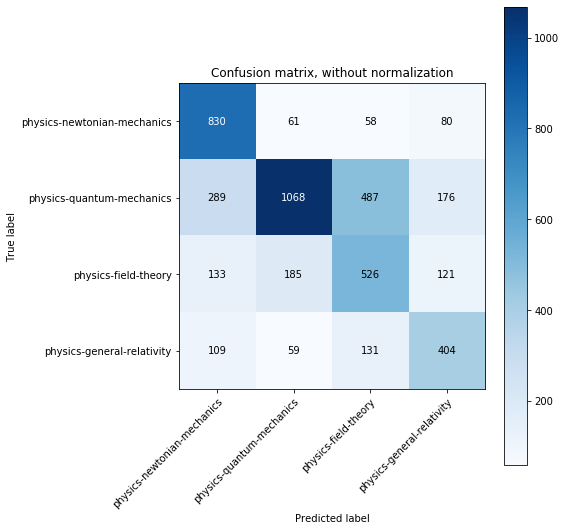

In [158]:
name = "model3_cluster4_epoch16_1"
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name)


Normalized confusion matrix
[[0.80660836 0.05928086 0.0563654  0.07774538]
 [0.14306931 0.52871287 0.24108911 0.08712871]
 [0.13782383 0.19170984 0.54507772 0.1253886 ]
 [0.15504979 0.08392603 0.18634424 0.57467994]]


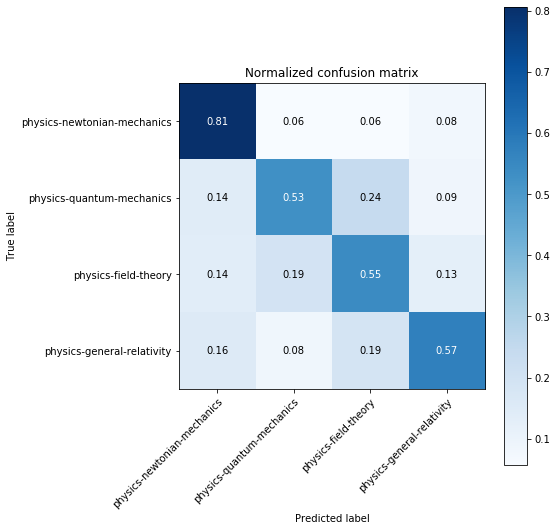

In [159]:
name = "model3_cluster4_epoch16_2"
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name, normalize=True)


In [160]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'yhat': [[0.0404881127178669,
   0.5921602845191956,
   0.323565810918808,
   0.043785836547613144]],
 'pred_index': 1,
 'label': 'physics-quantum-mechanics'}

In [161]:
display_top_losses(predictions, 20)

,Equation,pred_label,Cluster_label,pred_index,Label,pred_conf
2410,m=1.67*10^{-27}kg,physics-newtonian-mechanics,physics-quantum-mechanics,0,1,0.982252
387614,M(v)=M_0\theta(v-v_0),physics-newtonian-mechanics,physics-field-theory,0,2,0.962653
26191,F_{12}=-F_{21},physics-newtonian-mechanics,physics-general-relativity,0,3,0.954975
244111,F = m \ddot x,physics-newtonian-mechanics,physics-quantum-mechanics,0,1,0.953732
40282,\mathbb{Z}^{*}=\mathbb{N}\cup\{0\},physics-field-theory,physics-newtonian-mechanics,2,0,0.949309
97706,"(P(u,u)=(P(d,d))=(\cfrac\phi\pi)",physics-field-theory,physics-quantum-mechanics,2,1,0.932463
253593,F = m a,physics-newtonian-mechanics,physics-quantum-mechanics,0,1,0.931991
153458,"g_{\mu\nu} = e^{2\phi}\delta_{\mu\nu}, \qquad ...",physics-general-relativity,physics-field-theory,3,2,0.929032
107129,"f(t,x,y)=F(t)+g(x)+h(y)",physics-newtonian-mechanics,physics-general-relativity,0,3,0.926652
427046,\phi_1(x) = (\frac{4}{\pi})^{\frac{1}{4}}\: x ...,physics-field-theory,physics-quantum-mechanics,2,1,0.926401
